In [1]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, masking
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm import expression_to_contrast_vector
from nilearn import plotting
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


This notebook covers the RT modeling sequence for the ABCD Study [Casey et al. 2018](www.doi.org/10.1016/j.dcn.2018.03.001) `Year2` MID task data. The RT framework is based on the theortical paradox described and simulated in [Mumford et al. 2023](www.doi.org/10.1038/s41562-023-01760-0) and previously demonstrated in n = 120/50 3-back working memory task and in n = 26 decision-making task [Yarkoni et al. 2009](www.doi.org/10.1371/journal.pone.0004257). 

In the current modeling of the MID task, consistent with prior litearture, we model the Anticipatory Cue and Feedback conditions. The Anticipatory model is defined as the onset and duration (2000ms) of the Cue stimulus (Loss/gain $5 or $0.20 and Neutral) and associated hit/miss feedback trails for each trial type (Loss/gain $5 or $0.20 and Neutral).

- `Section 1`. Defined Functions & setting of primary paths
- `Section 2`. Conversion of t-statistic group map images to cohen's D maps.
- `Section 3`. Calculating mRTs to use in group model + extract R/L Nacc [weighted Fixed Eff](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L189C42-L191C88) and conditions RTs. Create plots across both.
- `Section 4`. Plotting group maps: Cohen's D for contrasts for RT and non-RT model, estimate difference between RT and non-RT maps, and probe mean ('int') and RT ('rt') group estimate.
- `Section 5`. Example design matrix for RT model using ABCD behavioral data. Providing associated design image and contrast matrix.

Several contrasts are modeled in the analyses as defined in the ABCD behavioral data:

- `Anticipation` - 'LRew-Neut': 'LgReward - Triangle',
- `Anticipation` - 'ARew-Neut': 'LgReward + SmallReward - 2*Triangle',
- `Anticipation` - 'LPun-Neut': 'LgPun - Triangle',
- `Anticipation` - 'APun-Neut': 'LgPun + SmallPun - 2*Triangle',
- `Feedback` - 'ARewHit-ARewMiss': 'LgReward_hit + SmallReward_hit - LgReward_miss - SmallReward_miss',
- `Feedback` - 'LRewHit-LRewMiss': 'LgReward_hit - LgReward_miss',
- `Feedback` - 'APunHit-APunMiss': 'LgPun_hit + SmallPun_hit - LgPun_miss - SmallPun_miss',
- `Feedback` - 'LPunHit-LPunMiss': 'LgPun_hit - LgPun_miss',
- `Feedback` - 'LRewHit-NeutHit': 'LgReward_hit - Triangle_hit',
- `Probe Resp.` - 'probe-base': 'probe',
- `Probe Resp.` - 'rt-base': 'probe_rt'


# 1. Functions + Path Spec

In [2]:
def nifti_tstat_to_cohensd(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Cohen's d.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating Cohen's d, Integer
    :return: NIfTI image containing Cohen's d.
    """
    d_img_path = tstat_path.replace('tstat', 'cohensd')
    
    if not os.path.exists(d_img_path):
        t_img = nib.load(tstat_path)
        # Get data array from the t-statistics image
        t_data = t_img.get_fdata()
        # Calculate Cohen's d using the t_stat / sqrt(n) formula
        d_data = t_data / np.sqrt(n)
        # Create a NIfTI image containing Cohen's d, with the same properties as the input image
        cohensd_img = image.new_img_like(t_img, d_data)
        cohensd_img.to_filename(d_img_path)
        end_img = f"Cohen's d img created: {d_img_path}"
    else:
        end_img = f"Cohen's d img exists: {d_img_path}"
        
    return print(end_img)

def create_hitmiss(events_df: pd.DataFrame, hit_col: str, condition_col: str) -> pd.DataFrame:

    # create a delinated hit v miss column so it is more clear
    feedback_hitmiss_lab = 'Feedback.Response'
    events_df[feedback_hitmiss_lab] = np.where(events_df[hit_col] == 1.0,
                                               events_df[condition_col] + '_hit',
                                               events_df[condition_col] + '_miss')
    return events_df

def calc_mask_avg(img, mask):
    masked_data = masking.apply_mask(image.load_img(img), mask)
    return np.round(np.mean(masked_data), 3)

In [4]:
session = 'ses-2YearFollowUpYArm1'
out_path = '/scratch.global/mdemiden/mid_rt_mod'
grpmap_path = f'{out_path}/group/{session}/session'
fix_path = f'{out_path}/firstlvl/{session}'
beh_path = '/home/feczk001/mdemiden/slurm_ABCD_s3/Beh_Data/events_to_tsv/2YearFollowUpYArm1_MID'
script_path='/home/feczk001/mdemiden/analyses/mid_rt_bold/scripts'
sub_list = f'{script_path}/cluster_jobs/subject_ids/ids_sub_2yr.tsv'
left_nac = f'{script_path}/brain_mask/Left_NAcc.nii.gz'
right_nac = f'{script_path}/brain_mask/Right_NAcc.nii.gz'

# 2. Convert t-maps to d-maps

In [ ]:
t_list = glob(os.path.join(grpmap_path,"subs-500_*_stat-tstat_*.nii.gz"))
for t_path in t_list:
    nifti_tstat_to_cohensd(tstat_path=t_path, n=500)

# 3. Calculate RT values

## 3.1 Calculate avg RT values for group estimates

Calculate RT values for each subjects (average across runs within each subject). Taking mean OverallRT within run per subject and then average the two for each subject for a single value per session. These are used in the group map estimation.

Specifically, two separate models are fit:
- mod-Cue-None: First Levl GLM include the 5 Anticipation, 10 Feedback, 4 Cosine Cosine (fMRIPrep estimated), 12 motion regressors (xyz+derivatives). The design matrix is specified in the github [here](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L123-L134)
- mod-Cue-RT: First Levl GLM include the 5 Anticipation, 10 Feedback, 1 probe, 1 response time, 4 Cosine Cosine (fMRIPrep estimated), 12 motion regressors (xyz+derivatives). The design matrix is specified in the github [here](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L97-L112)

Across the anticipory and feedback contrasts decribed above. The group maps estimate a [mean map ('int') and association with the mRT (rt)](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/group_estimate.py#L35-L53).

In [58]:
out_rts = []

sub_df = pd.read_csv(sub_list, sep='\t',header=None)
for sub in sub_df[0]:    
    run1 = f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-01_events.tsv'
    run1_df = pd.read_csv(run1, sep='\t')
    avg_rt1 = round(run1_df['OverallRT'].mean(),3)
    
    run2 = f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-02_events.tsv'
    run2_df = pd.read_csv(run2, sep='\t')
    avg_rt2 = round(run2_df['OverallRT'].mean(),3)

    avg_rts = round(np.mean([avg_rt1,avg_rt2]),3)
    out_rts.append({'Subject': sub, 'Average_RT': avg_rts})
    
out_rts_df = pd.DataFrame(out_rts)
out_rts_df.to_csv(f'{out_path}/subs_avg-overall-rts.csv', index=False)

## 3.2 Run Avg Betas + Conditional RTs

In [2]:
fb_contrasts = {
    'ARewHit-ARewMiss': ['LgReward_hit','SmallReward_hit','LgReward_miss','SmallReward_miss'],
    'LRewHit-LRewMiss': ['LgReward_hit','LgReward_miss'], 
    'APunHit-APunMiss': ['LgPun_hit','SmallPun_hit','LgPun_miss','SmallPun_miss'],
    'LPunHit-LPunMiss': ['LgPun_hit','LgPun_miss'], 
    'LRewHit-NeutHit': ['LgReward_hit', 'Triangle_hit']
}

In [56]:
sub_ids = []
label_list = []
left_rt_mod_list = []
right_rt_mod_list = []
left_non_rt_list = []
right_non_rt_list = []
r1_avg_a_list = []
r2_avg_a_list = []
r1_avg_b_list = []
r2_avg_b_list = []

ran_fixeff_dirs = [d for d in os.listdir(fix_path) if os.path.isdir(os.path.join(fix_path, d)) and d.startswith('sub-')]

for sub in ran_fixeff_dirs:
    # create hit/miss feedback consistent with first lvl models
    r1_df = pd.read_csv(f'{beh_path}/{sub}_{session}_task-MID_run-01_events.tsv', sep='\t')
    r2_df = pd.read_csv(f'{beh_path}/{sub}_{session}_task-MID_run-02_events.tsv', sep='\t')
    r1_df = create_hitmiss(r1_df, 'prbacc','Condition')
    r2_df = create_hitmiss(r2_df, 'prbacc','Condition')

    # iterate over contrsat label + Feedback.Response elements to calcualte RTs & extra run avg beta weights 
    for label, contrast  in fb_contrasts.items():
        cue_rt_img = f'{fix_path}/{sub}/{sub}_{session}_task-MID_contrast-{label}_mod-Cue-rt_stat-effect.nii.gz'
        cue_none_img = f'{fix_path}/{sub}/{sub}_{session}_task-MID_contrast-{label}_mod-Cue-None_stat-effect.nii.gz'
        rtmod_leftnac = calc_mask_avg(cue_rt_img, left_nac)
        rtmod_rightnac = calc_mask_avg(cue_rt_img, right_nac)
        nort_leftnac = calc_mask_avg(cue_none_img, left_nac)
        nort_rightnac = calc_mask_avg(cue_none_img, right_nac)

        # constrain Feedback cues to elements used in contrast
        filt_r1 = r1_df[r1_df['Feedback.Response'].isin(contrast)].dropna(subset=['OverallRT'])
        filt_r2 = r2_df[r2_df['Feedback.Response'].isin(contrast)].dropna(subset=['OverallRT'])

        # Lg+small hit + Lg + small miss = four elements, otherwise feedback has 2 elements (e.g. lg hit > lg miss)
        if len(contrast) > 2:
            # hit mRTs 
            r1_avg_a = filt_r1[filt_r1['Feedback.Response'].str.endswith('_hit')]['OverallRT'].mean()
            r2_avg_a = filt_r2[filt_r2['Feedback.Response'].str.endswith('_hit')]['OverallRT'].mean()
            # miss mRTs
            r1_avg_b = filt_r1[filt_r1['Feedback.Response'].str.endswith('_miss')]['OverallRT'].mean()
            r2_avg_b = filt_r2[filt_r2['Feedback.Response'].str.endswith('_miss')]['OverallRT'].mean()
            
        elif len(contrast) <= 2:
            r1_avg_a = filt_r1[filt_r1['Feedback.Response'] == contrast[0]]['OverallRT'].mean()
            r2_avg_a = filt_r2[filt_r2['Feedback.Response'] == contrast[0]]['OverallRT'].mean()

            r1_avg_b = filt_r1[filt_r1['Feedback.Response'] == contrast[1]]['OverallRT'].mean()
            r2_avg_b = filt_r2[filt_r2['Feedback.Response'] == contrast[1]]['OverallRT'].mean()

        # Append to lists
        sub_ids.append(sub)
        label_list.append(label)
        left_rt_mod_list.append(rtmod_leftnac)
        right_rt_mod_list.append(rtmod_rightnac)
        left_non_rt_list.append(nort_leftnac)
        right_non_rt_list.append(nort_rightnac)
        r1_avg_a_list.append(r1_avg_a)
        r2_avg_a_list.append(r2_avg_a)
        r1_avg_b_list.append(r1_avg_b)
        r2_avg_b_list.append(r2_avg_b)

In [112]:
comb_vars = {
    'sub': sub_ids,
    'contrast': label_list,
    'left_rt_mod': left_rt_mod_list,
    'right_rt_mod': right_rt_mod_list,
    'left_none_rt': left_non_rt_list,
    'right_none_rt': right_non_rt_list,
    'r1_avg_a': r1_avg_a_list,
    'r2_avg_a': r2_avg_a_list,
    'r1_avg_b': r1_avg_b_list,
    'r2_avg_b': r2_avg_b_list
}

betas_rts_df = pd.DataFrame(comb_vars)
betas_rts_df.to_csv(f'{out_path}/subs_betas-rts.csv', index=False)

In [5]:
betas_df = pd.read_csv(f'{out_path}/subs_betas-rts.csv', sep=',')
len(betas_df)

2500

## 3.3 Making plots RTs for contrasts ~ estimates

1. plot Left (& Right) Nacc signal difference against `mean RTs for that specific contrast`
2. plot Left (& Right) Nacc signal difference against `against the different between hit and miss RTs for that specififc contrast`

In [84]:
# create varibles plot 1
betas_df['leftnac_diffmods'] = betas_df['left_none_rt'] - betas_df['left_rt_mod']
betas_df['rightnac_diffmods'] = betas_df['right_none_rt'] - betas_df['right_rt_mod']
betas_df['mrt_ab'] = (betas_df['r1_avg_a'] + betas_df['r2_avg_a'] +  betas_df['r1_avg_b'] + betas_df['r2_avg_b'])/4

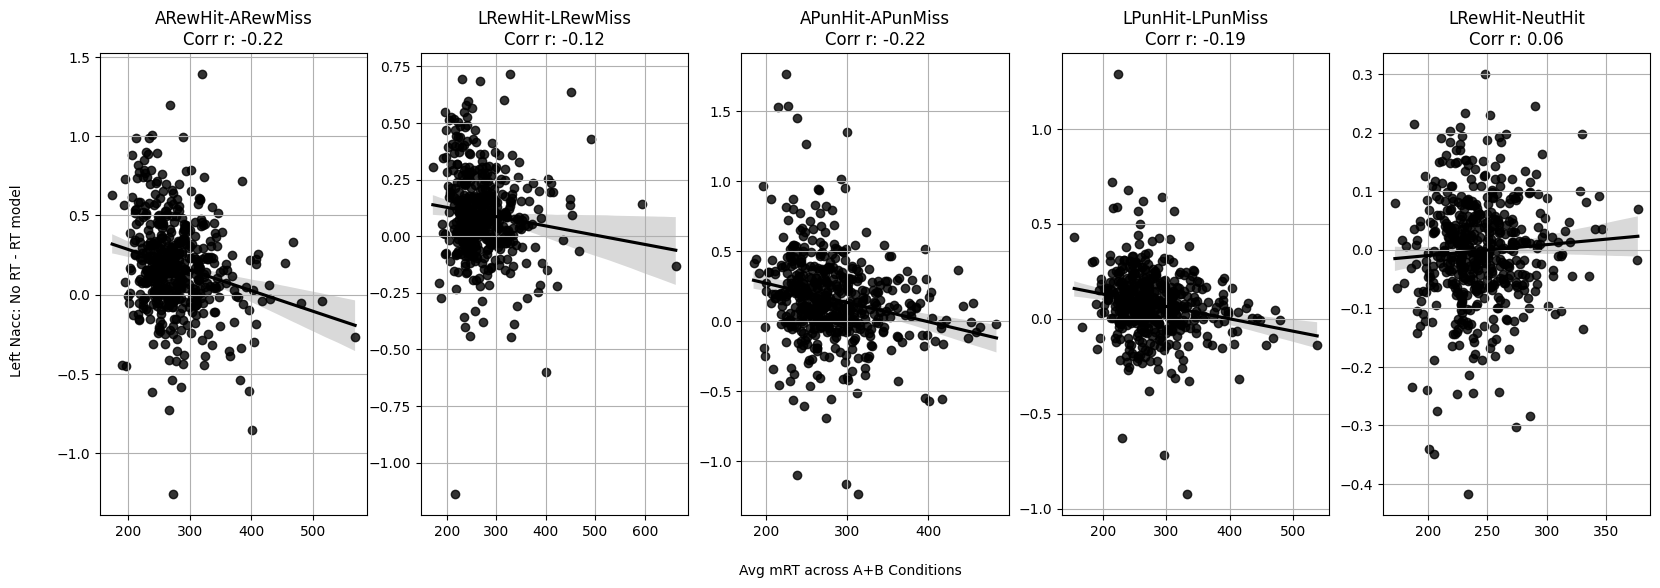

In [102]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
roi_lab = 'leftnac_diffmods'
for i, (label, contrast) in enumerate(fb_contrasts.items()):
     # constrain Feedback cues to elements used in contrast
    contrast_subset = betas_df[betas_df['contrast'] == label]
    corr_val = contrast_subset[['mrt_ab',roi_lab]].corr()[roi_lab]

    # Plot in the corresponding subplot
    sns.regplot(data=contrast_subset, x='mrt_ab', y=roi_lab, color='black', ax=axes[i])
    
    # Set title, labels, and add correlation coefficient to the plot
    axes[i].set_title(f'{label}\nCorr r: {round(corr_val[0], 2)}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

# Add common x and y labels
fig.text(0.5, 0.01, 'Avg mRT across A+B Conditions', ha='center')
fig.text(0.08, 0.5, 'Left Nacc: No RT - RT model', va='center', rotation='vertical')
plt.show()

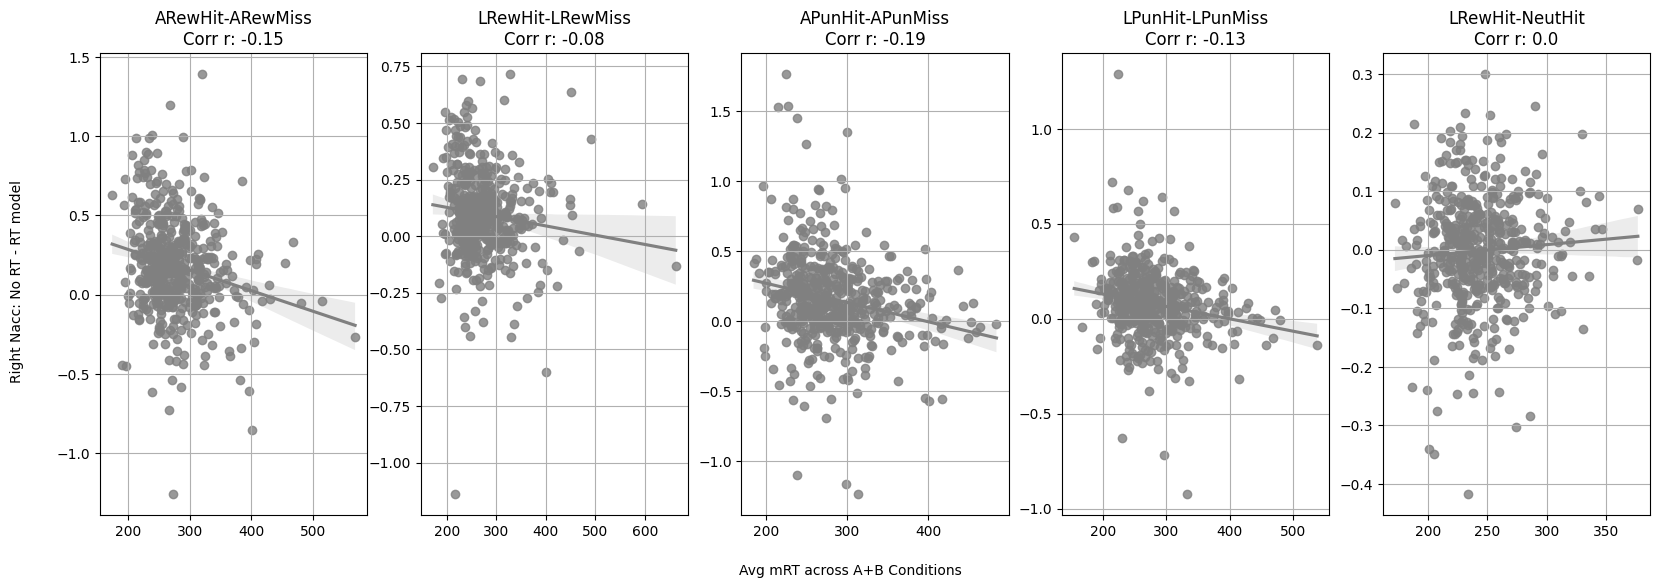

In [101]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
roi_lab = 'rightnac_diffmods'
for i, (label, contrast) in enumerate(fb_contrasts.items()):
    contrast_subset = betas_df[betas_df['contrast'] == label]
    corr_val = contrast_subset[['mrt_ab',roi_lab]].corr()[roi_lab]

    sns.regplot(data=contrast_subset, x='mrt_ab', y='leftnac_diffmods', color='grey', ax=axes[i])
    axes[i].set_title(f'{label}\nCorr r: {round(corr_val[0], 2)}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

# Add common x and y labels
fig.text(0.5, 0.01, 'Avg mRT across A+B Conditions', ha='center')
fig.text(0.08, 0.5, 'Right Nacc: No RT - RT model', va='center', rotation='vertical')
plt.show()

In [106]:
# create varibles plot 2
betas_df['diff_mrt_ab'] = ((betas_df['r1_avg_a'] + betas_df['r2_avg_a'])/2) -  ((betas_df['r1_avg_b'] + betas_df['r2_avg_b'])/2)

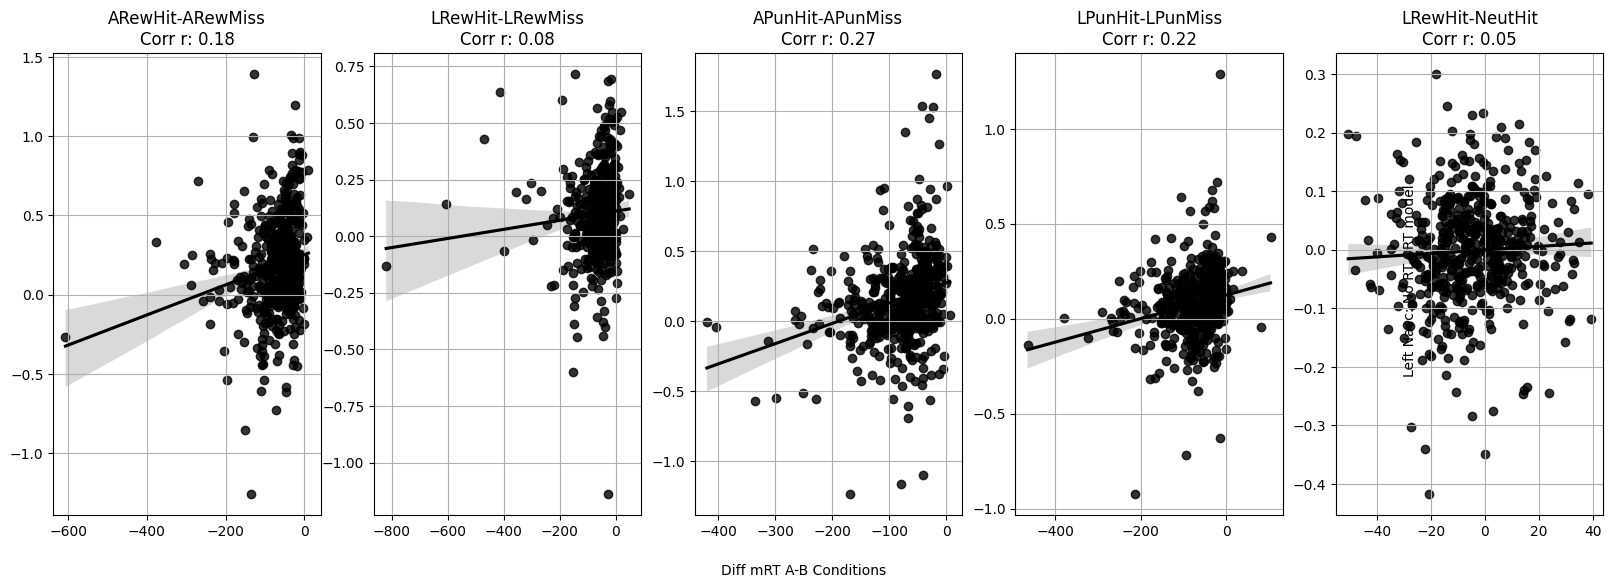

In [107]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
roi_lab = 'leftnac_diffmods'
for i, (label, contrast) in enumerate(fb_contrasts.items()):
     # constrain Feedback cues to elements used in contrast
    contrast_subset = betas_df[betas_df['contrast'] == label]
    corr_val = contrast_subset[['diff_mrt_ab',roi_lab]].corr()[roi_lab]

    sns.regplot(data=contrast_subset, x='diff_mrt_ab', y=roi_lab, color='black', ax=axes[i])
    axes[i].set_title(f'{label}\nCorr r: {round(corr_val[0], 2)}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

fig.text(0.5, 0.01, 'Diff mRT A-B Conditions', ha='center')
fig.text(0.8, 0.5, 'Left Nacc: No RT - RT model', va='center', rotation='vertical')
plt.show()

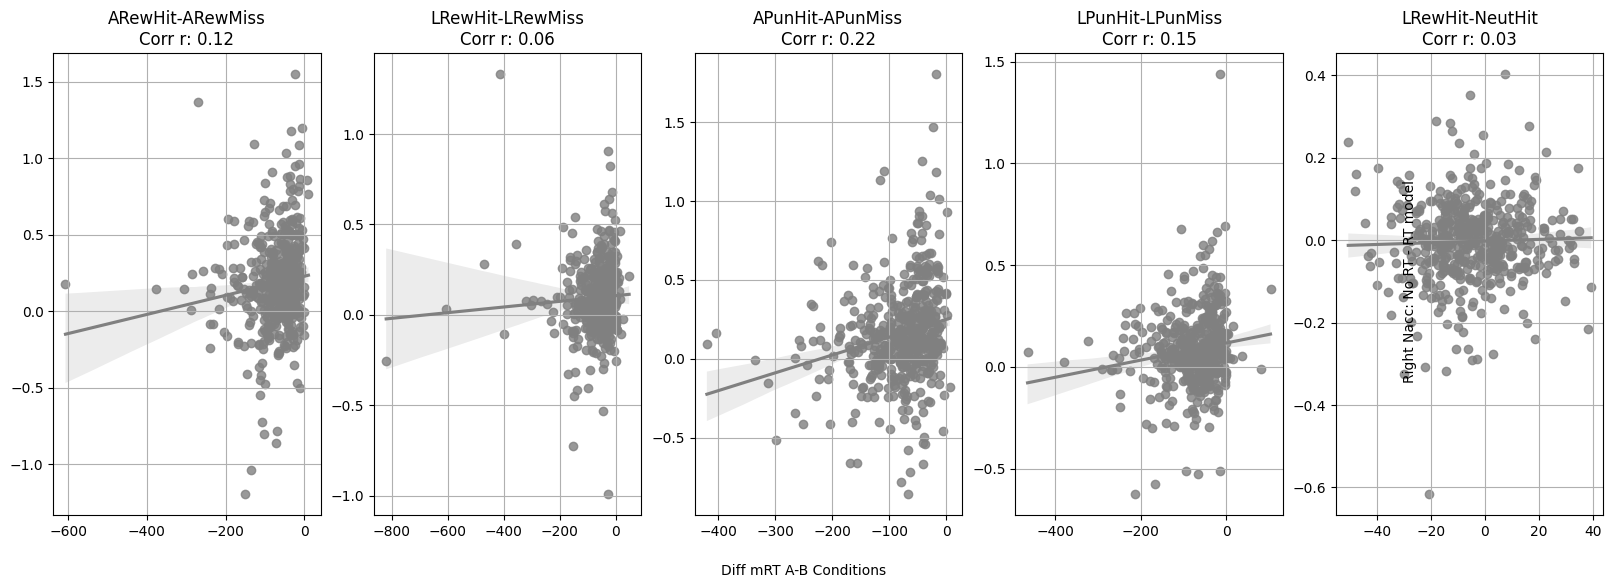

In [108]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
roi_lab = 'rightnac_diffmods'
for i, (label, contrast) in enumerate(fb_contrasts.items()):
     # constrain Feedback cues to elements used in contrast
    contrast_subset = betas_df[betas_df['contrast'] == label]
    corr_val = contrast_subset[['diff_mrt_ab',roi_lab]].corr()[roi_lab]

    # Plot in the corresponding subplot
    sns.regplot(data=contrast_subset, x='diff_mrt_ab', y=roi_lab, color='grey', ax=axes[i])
    
    # Set title, labels, and add correlation coefficient to the plot
    axes[i].set_title(f'{label}\nCorr r: {round(corr_val[0], 2)}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

fig.text(0.5, 0.01, 'Diff mRT A-B Conditions', ha='center')
fig.text(0.8, 0.5, 'Right Nacc: No RT - RT model', va='center', rotation='vertical')
plt.show()

# 4. Plotting Group maps

In [109]:
# group level contrast 
contrasts_reg = [
    # anticipatory contrasts for cue-model
    'LRew-Neut', 'ARew-Neut', 'LPun-Neut', 'APun-Neut',
    # feedback contrasts
    'ARewHit-ARewMiss', 'LRewHit-LRewMiss', 'APunHit-APunMiss',
    'LPunHit-LPunMiss', 'LRewHit-NeutHit'
]
# rt versus non-rt model
models = ['Cue-rt', 'Cue-None']
# thresh/coordinate
spec_coords = (12,8,-10)
d_thresh = .2
d_max =1

## 4.1 Group Map: `mod-Cue-rt` vs `mod-Cue-None`

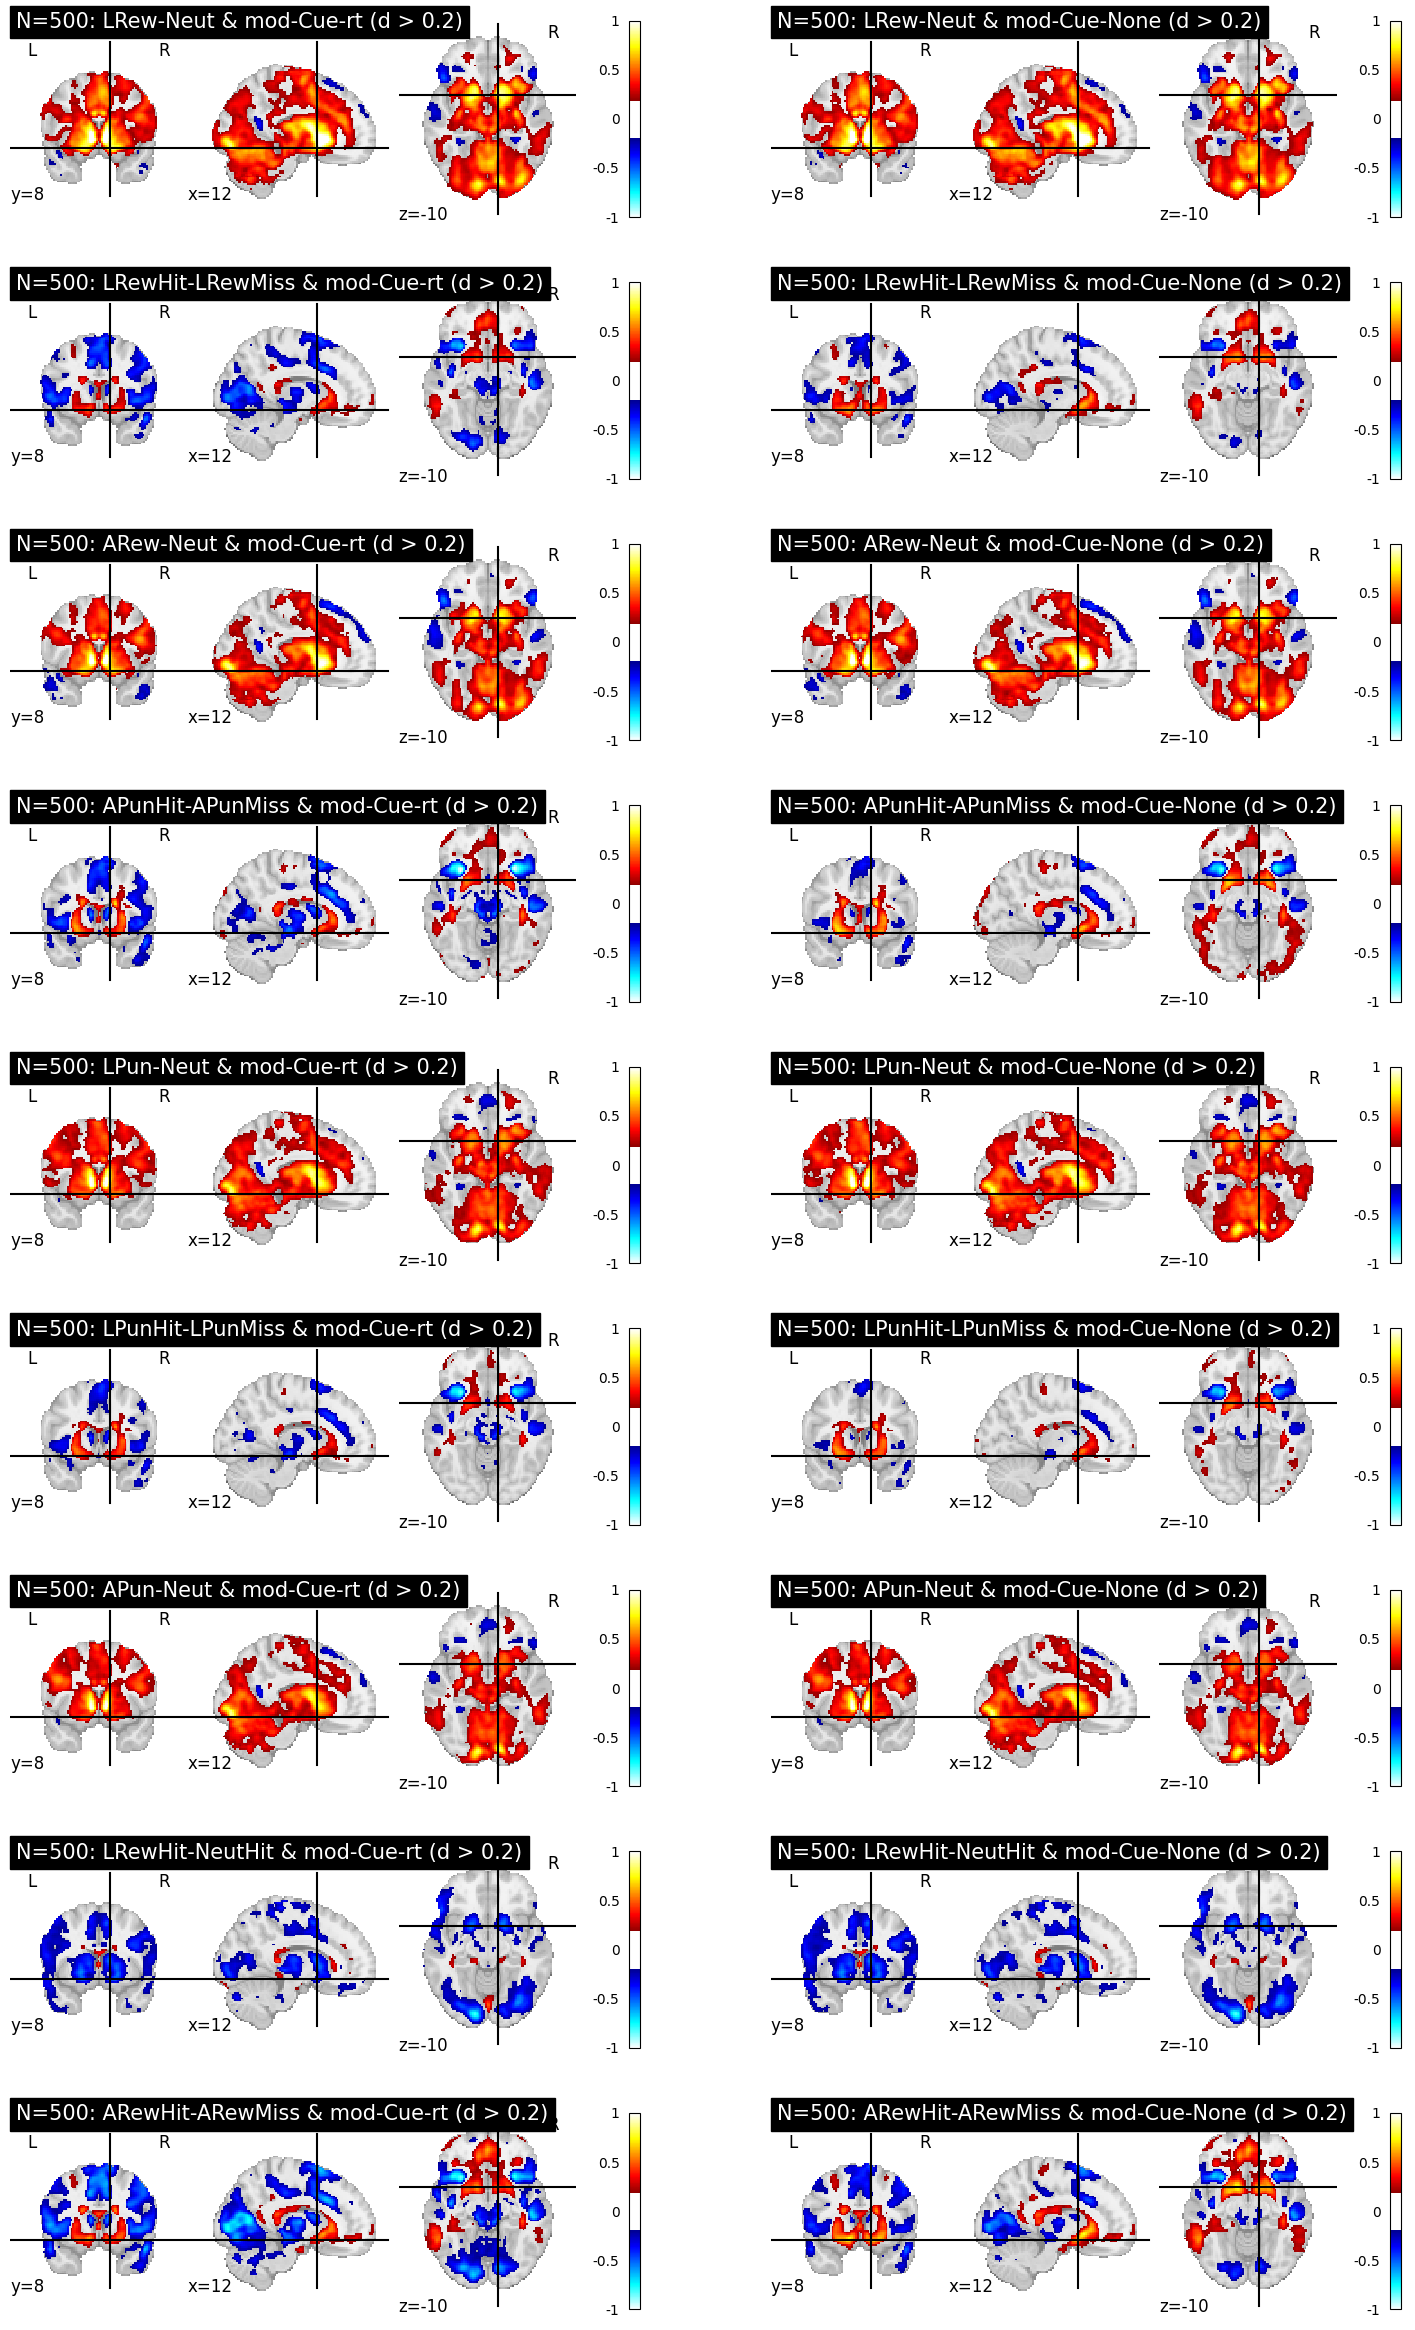

In [157]:
n_cols = 2
n_rows = len(contrasts_reg)
fig, axes = plt.subplots(len(contrasts_reg), n_cols, figsize=(18,30))

for mod in ['mod-Cue-rt', 'mod-Cue-None']:
    for i, con in enumerate(contrasts_reg):
        con_img = glob(f'{grpmap_path}/subs-500_*{con}_{mod}_stat-cohensd_int.nii.gz')[0]
        row = (i * 2) % n_rows  # Ensure row stays within the range of n_rows
        col = ['mod-Cue-rt', 'mod-Cue-None'].index(mod)
        plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               title=f"N=500: {con} & {mod} (d > {d_thresh})", threshold=d_thresh, draw_cross=True,
                               vmax=d_max, colorbar=True,
                               axes=axes[row, col])

plt.show()

## 4.2 Diff Maps.  `mod-Cue-None` - `mod-Cue-rt`

/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


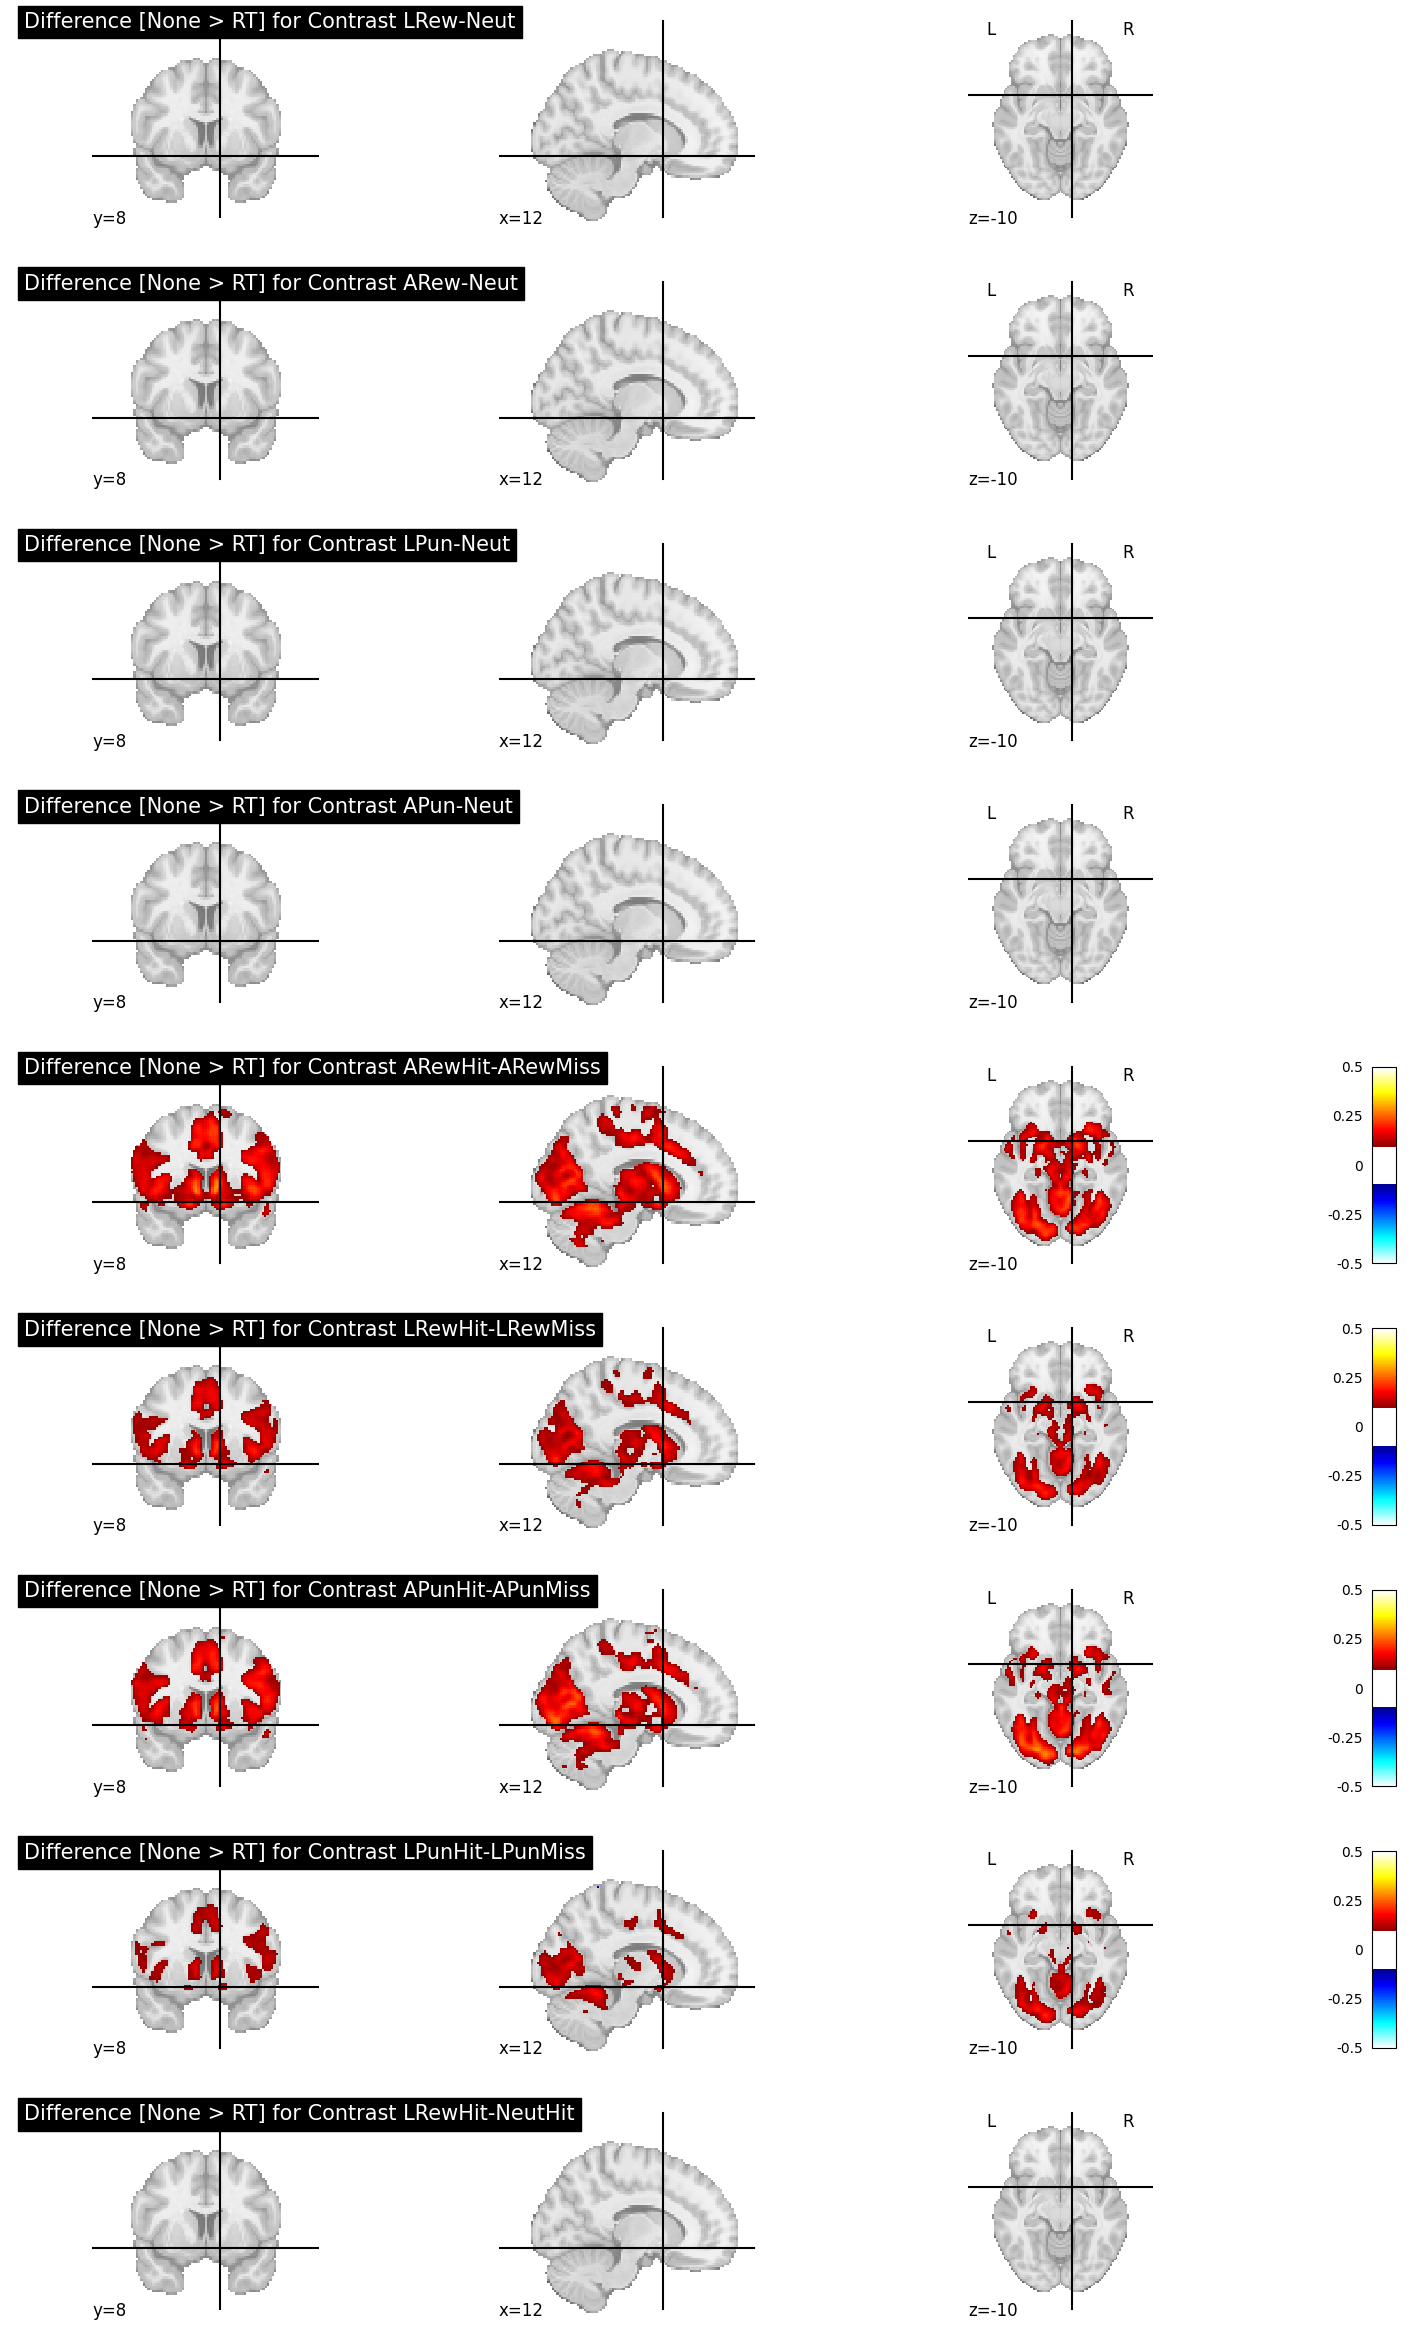

In [158]:
rt_minus_none = []
for i, con in enumerate(contrasts_reg):
    con_img_rt = nib.load(glob(f'{grpmap_path}/subs-500_*{con}_mod-Cue-rt_stat-cohensd_int.nii.gz')[0])
    con_img_none = nib.load(glob(f'{grpmap_path}/subs-500_*{con}_mod-Cue-None_stat-cohensd_int.nii.gz')[0])
    
    con_data_rt = con_img_rt.get_fdata()
    con_data_none = con_img_none.get_fdata()
    difference =  con_data_none - con_data_rt
    diff_img = nib.Nifti1Image(difference, con_img_rt.affine)
    
    rt_minus_none.append((diff_img, con))  # Store the difference image along with the contrast label

fig, axes = plt.subplots(len(contrasts_reg), 1, figsize=(18, 30))
for i, (img, con) in enumerate(rt_minus_none):
    plotting.plot_stat_map(stat_map_img=img, cut_coords=spec_coords,
                           display_mode="ortho",
                           title=f"Difference [None > RT] for Contrast {con}", threshold=.1, draw_cross=True,
                           vmax=.5, colorbar=True,
                           axes=axes[i])

plt.show()

## 4.3 Probe Maps: int & rt for probe-base and rt-base

/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


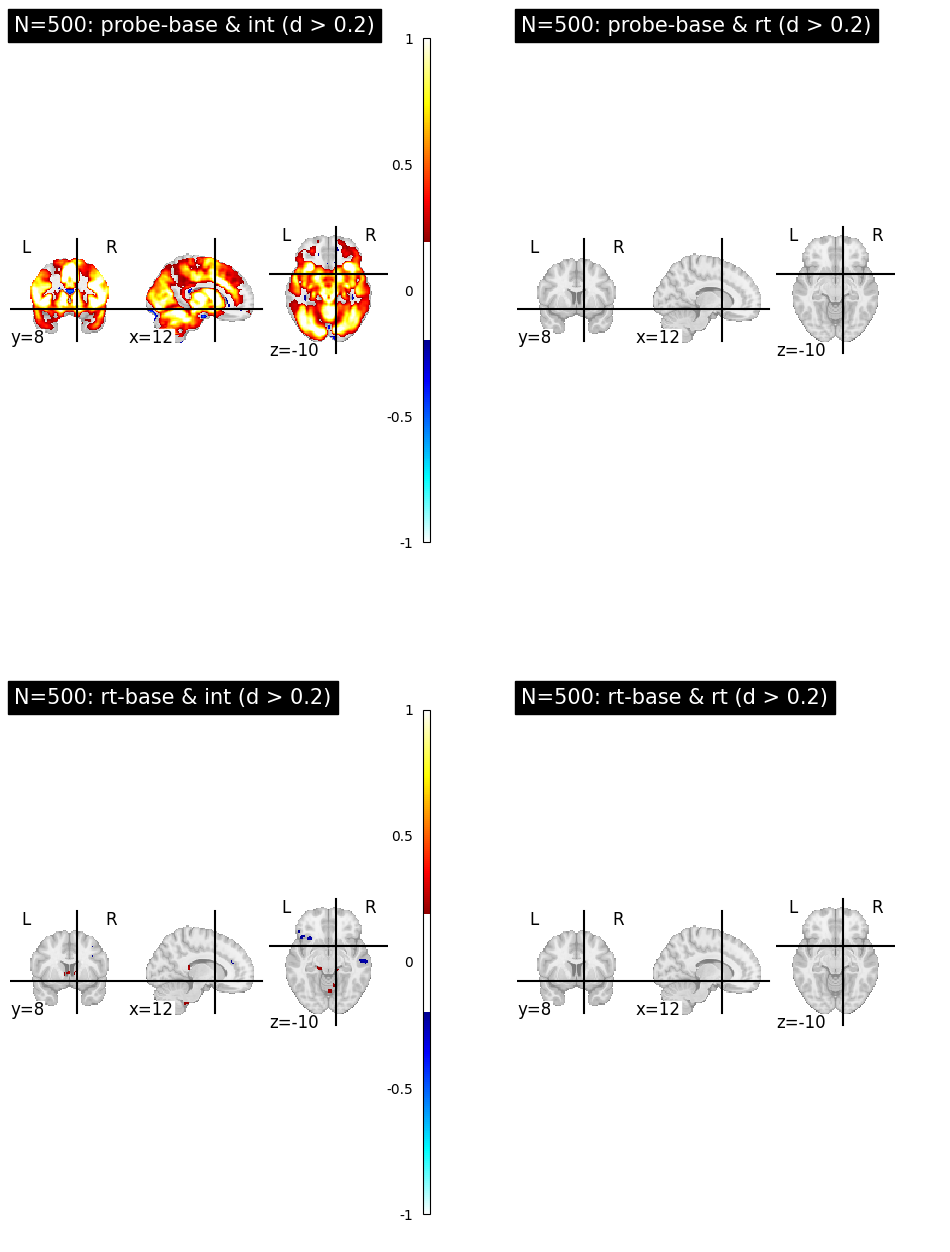

In [111]:
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16))

for i, con in enumerate(['probe-base', 'rt-base']):
    for j, val in enumerate(['int', 'rt']):
        con_img = glob(f'{grpmap_path}/subs-500_*{con}_mod-Cue-rt_stat-cohensd_{val}.nii.gz')[0]
        row = i  # Use i as row index
        col = j  # Use j as column index
        plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,
                               display_mode="ortho",
                               title=f"N=500: {con} & {val} (d > {d_thresh})", threshold=d_thresh, draw_cross=True,
                               vmax=d_max, colorbar=True,
                               axes=axes[row, col])

plt.show()

# 5. Example RT Design Matrix (w/o cosine+mot)

Set paths and load the behavioral data for n = 1

In [65]:
beh_n1 = glob(f'{beh_path}/*_task-MID_run-01_events.tsv')[3]

In [66]:
events_df = pd.read_csv(beh_n1,sep='\t')
events_df.columns

Index(['Subject', 'Handedness', 'Run', 'SubTrial', 'Condition',
       'Cue.OnsetTime', 'Cue.Duration', 'Anticipation.Duration',
       'Anticipation.OnsetTime', 'Probe.Duration', 'Probe.OnsetTime',
       'Probe.RESP', 'Result', 'prbacc', 'prbrt', 'OverallRT', 'meanrt',
       'moneyamt', 'ResponseCheck', 'Feedback.OnsetTime', 'FeedbackDuration',
       'SessionDate', 'TriggerTime', 'TriggerTimeAlt', 'DiffTriggerTimes'],
      dtype='object')

In [67]:
events_df[['Probe.Duration', 'Probe.OnsetTime','OverallRT']]

,Probe.Duration,Probe.OnsetTime,OverallRT
0,0.257,6.482,NaN
1,0.257,11.982,237.0
2,0.257,17.481,254.0
3,0.237,23.481,NaN
4,0.237,29.480,269.0
5,0.237,34.980,263.0
6,0.237,40.479,258.0
7,0.237,45.979,220.0
8,0.257,51.978,235.0
9,0.257,59.977,256.0


## 5.1 Set up condition and conditional RT examples. 

Question...

ABCD - 
Reward Hit - Reward Miss ($5/0.20)
Reward Hit - Neutral hit 

If RT effect - adjust If contrast for feedback --> decreases effect = okay?

First: Create a more consistent hit/miss Feedback column based on probe accuracy

In [68]:
events_df['Feedback.Response'] = np.where(events_df['prbacc'] == 1.0,
                                          events_df['Condition'] + '_hit',
                                          events_df['Condition'] + '_miss')

In [69]:
events_df[['Feedback.Response','OverallRT']].groupby('Feedback.Response').mean('OverallRT')

,OverallRT
Feedback.Response,
LgPun_hit,242.800000
LgPun_miss,285.000000
LgReward_hit,234.000000
LgReward_miss,259.000000
SmallPun_hit,243.000000
SmallPun_miss,288.666667
SmallReward_hit,247.000000
SmallReward_miss,259.500000
Triangle_hit,251.250000


## 5.2 Set up design matrix

Create stacked conditions, onsets and durations to be used in first level. 

In order of phases modeled:

Anticipation:
1. Condition
2. Cue.OnsetTime
3. Cue.Duration

Feedback:
1. Feedback.Response
2. Feedback.OnsetTime
3. Feedback.Duration

Two probe regressor:

Probe - Regressor 1: Probe.OnsetTime + Probe.duration

Prone_rt - Regressor 2: Probe.OnsetTime + OverallRT / 1000

Probe:
1. Constant probe cue
2. Probe.OnsetTime
3. Probe.Duration

Probe_rt:
1. Constant probe_rt label -- omit rows w/o response
2. Probe.OnsetTime -- omit rows w/o response
3. OverallRT -- duration is the RT time, omit rows w/o response (ms --> sec)



In [70]:
conditions = pd.concat([events_df.loc[:, "Condition"], 
                        events_df.loc[:, "Feedback.Response"],
                        pd.Series(["probe"] * len(events_df[['OverallRT','Probe.OnsetTime']])),
                        pd.Series(["probe_rt"] * len(events_df[['OverallRT','Probe.OnsetTime']].dropna()))
                       ], ignore_index=True)
onsets = pd.concat([events_df.loc[:, 'Cue.OnsetTime'], 
                    events_df.loc[:, "Feedback.OnsetTime"],
                    events_df.loc[:, "Probe.OnsetTime"],
                    events_df[['OverallRT','Probe.OnsetTime']].dropna()['Probe.OnsetTime']
                   ], ignore_index=True)
duration = pd.concat([events_df.loc[:, 'Cue.Duration'], 
                      events_df.loc[:, "FeedbackDuration"],
                      events_df.loc[:, "Probe.Duration"],
                      (events_df[['OverallRT','Probe.OnsetTime']].dropna()['OverallRT'])/1000
                     ], ignore_index=True)

# create pandas df with events
design_events = pd.DataFrame({
    'trial_type': conditions,
    'onset': onsets,
    'duration': duration
})

In [71]:
design_events

,trial_type,onset,duration
0,LgPun,2.000,2.000
1,LgReward,8.499,2.000
2,LgPun,13.998,2.000
3,SmallReward,19.498,2.000
4,Triangle,25.514,2.000
...,...,...,...
187,probe_rt,285.955,0.227
188,probe_rt,293.954,0.276
189,probe_rt,300.954,0.303
190,probe_rt,307.453,0.272


## 5.3 Fit Design matrix based on TR/vols

Create nilean design matrix for n volumes + bold TR in MID ABCD w/o stc and spm model.
Subsequent versions will include dift models calculated by fmriprep + x,y,z + derivatives motion regressors

In [72]:
# vols / tr
num_volumes = 403
bold_tr = .800

# Using the BOLD tr and volumes to generate the frame_times: acquisition time in seconds
frame_times = np.arange(num_volumes) * bold_tr

design_matrix_mid = make_first_level_design_matrix(
    frame_times=frame_times,
    events=design_events,
    hrf_model='spm', drift_model=None, add_regs=None
    )

In [73]:
reorder_cols = ['constrant',
                'LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
                'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
                'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
                'LgPun_hit', 'LgPun_miss', 'probe','probe_rt']
design_matrix_mid = design_matrix_mid.reindex(columns=reorder_cols)
print("Size of design matrix minus intercept:", design_matrix_mid.shape[-1]-1)

Size of design matrix minus intercept: 17


<AxesSubplot:label='conditions', ylabel='scan number'>

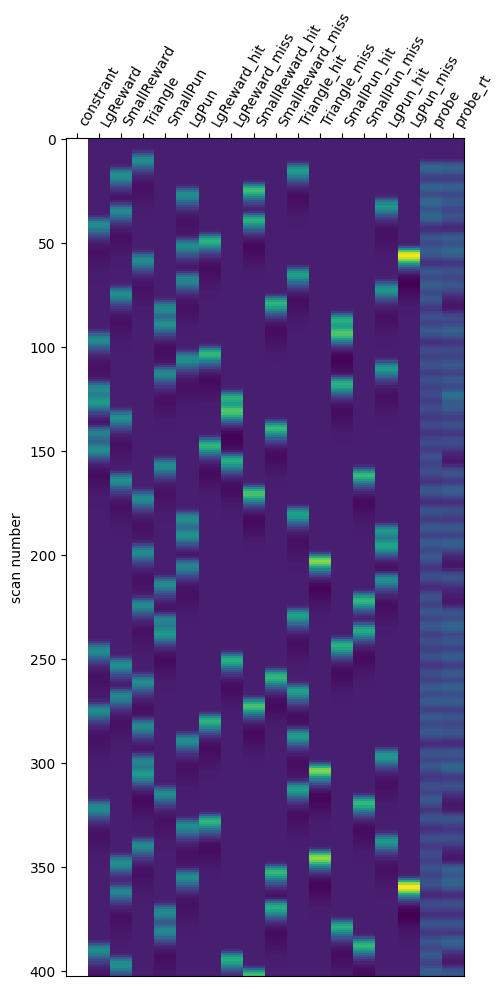

In [11]:
design_events.to_csv(f'{dir_out}/design_events_df.csv', index=False)
plotting.plot_design_matrix(design_matrix_mid)

## 5.4 Example of contrasts and contrast matrix

In [74]:
contrast_labs = {
    # Anticipation
    'LRew-Neut': 'LgReward - Triangle',
    'ARew-Neut': 'LgReward + SmallReward - 2*Triangle',
    'LPun-Neut': 'LgPun - Triangle',
    'APun-Neut': 'LgPun + SmallPun - 2*Triangle',

    # Feedback
    'ARewHit-ARewMiss': 'LgReward_hit + SmallReward_hit - LgReward_miss - SmallReward_miss',
    'LRewHit-LRewMiss': 'LgReward_hit - LgReward_miss',
    'APunHit-APunMiss': 'LgPun_hit + SmallPun_hit - LgPun_miss - SmallPun_miss',
    'LPunHit-LPunMiss': 'LgPun_hit - LgPun_miss',
    'LRewHit-LNeutHit': 'LgReward_hit - Triangle_hit',

    #probe
    'probe-base': 'probe',
    'rt-base': 'probe_rt'

}

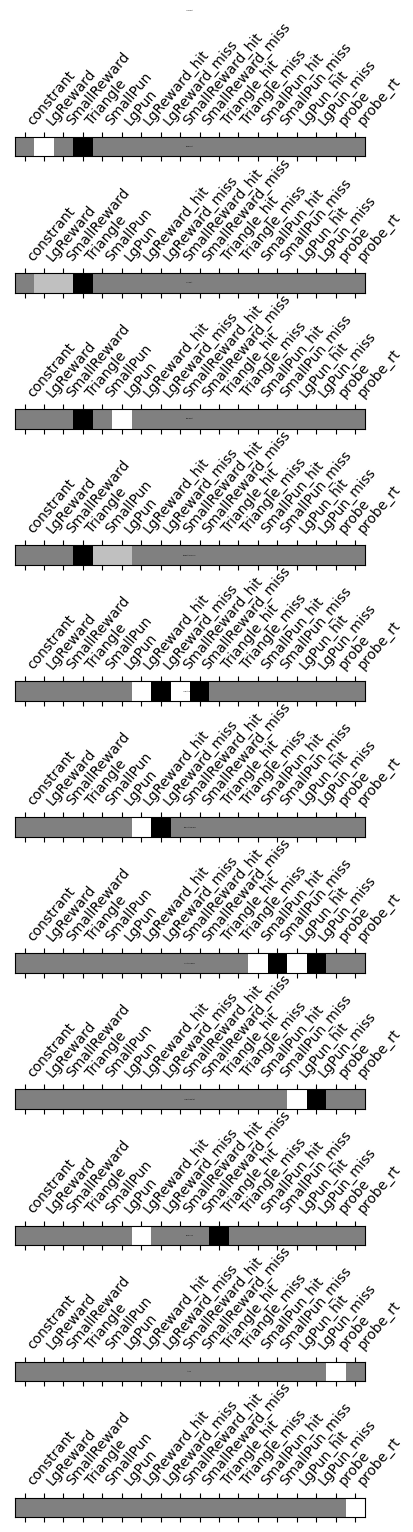

In [14]:
fig, axes = plt.subplots(nrows=len(contrast_labs), ncols=1, figsize=(400, 40))

# Plot each contrast matrix on a separate subplot
for i, (key, values) in enumerate(contrast_labs.items()):
    ax = axes[i]  # Select the appropriate subplot
    plotting.plot_contrast_matrix(values, design_matrix=design_matrix_mid, ax=ax)
    ax.set_title(key, fontsize=.0005)  # Set title for each subplot with smaller font size
plt.subplots_adjust(hspace=6)  # Add space between subplots
plt.show()

In [75]:
vals = design_matrix_mid.columns.values
print(' '.join(vals))

constrant LgReward SmallReward Triangle SmallPun LgPun LgReward_hit LgReward_miss SmallReward_hit SmallReward_miss Triangle_hit Triangle_miss SmallPun_hit SmallPun_miss LgPun_hit LgPun_miss probe probe_rt


In [34]:
for i, (key, values) in enumerate(contrast_labs.items()):
    print(key,'\n',expression_to_contrast_vector(values, design_columns=design_matrix_mid.columns))

LRew-Neut 
 [ 0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
ARew-Neut 
 [ 0.  1.  1. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
LPun-Neut 
 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
APun-Neut 
 [ 0.  0.  0. -2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
ARewHit-ARewMiss 
 [ 0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
LRewHit-LRewMiss 
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
APunHit-APunMiss 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.]
LPunHit-LPunMiss 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.]
LRewHit-LNeutHit 
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
probe-base 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
rt-base 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
